In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

## 4 Special Moves

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
#special_probs = {"break": 0.5, "combine": 0.5}
special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

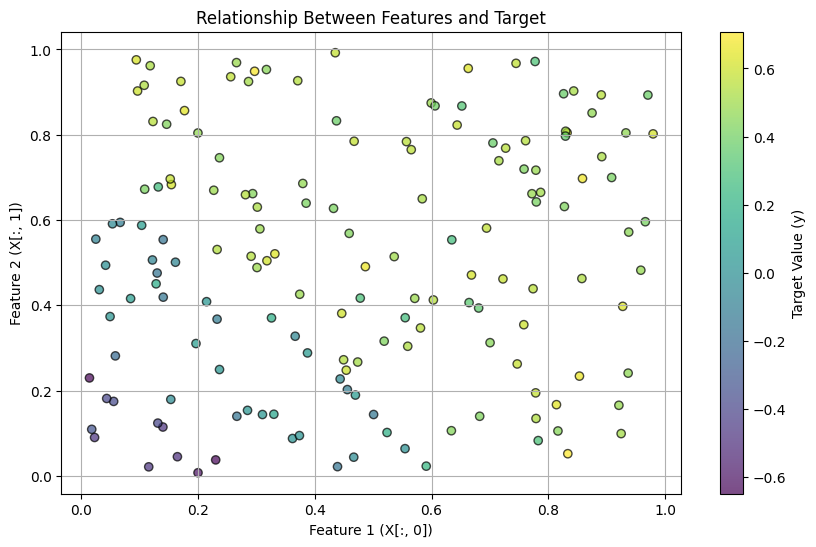

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y)')
plt.title('Relationship Between Features and Target')
plt.xlabel('Feature 1 (X[:, 0])')
plt.ylabel('Feature 2 (X[:, 1])')
plt.grid(True)
plt.show()

In [4]:
bart = ChangeNumTreeBART(ndpost=2000, nskip=2000, n_trees=100, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0 = 100, theta_df = np.inf, 
                         tree_num_prior_type="poisson", special_move_interval=1)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 4000/4000 [01:18<00:00, 50.91it/s] 


In [5]:
bart.trace[-1].n_trees

29

In [6]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.00184704]), 'ntree_theta': 100}

In [7]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

22.8325

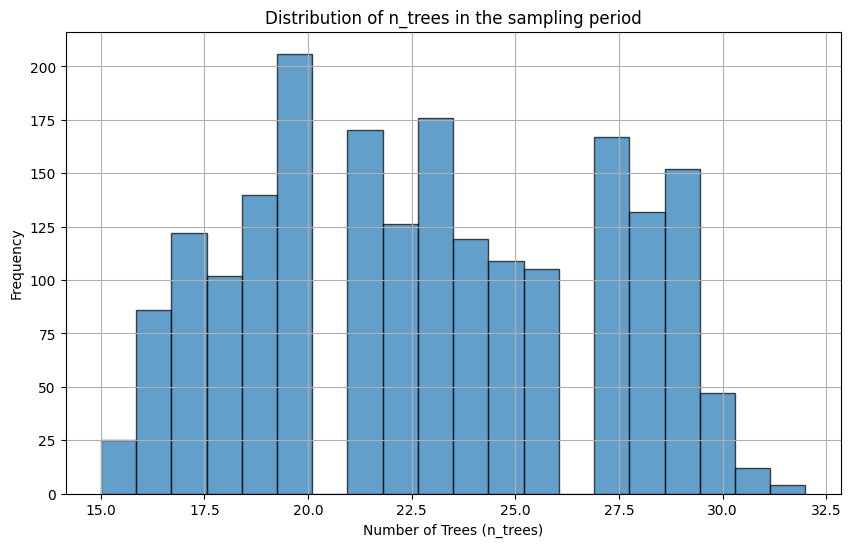

In [8]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

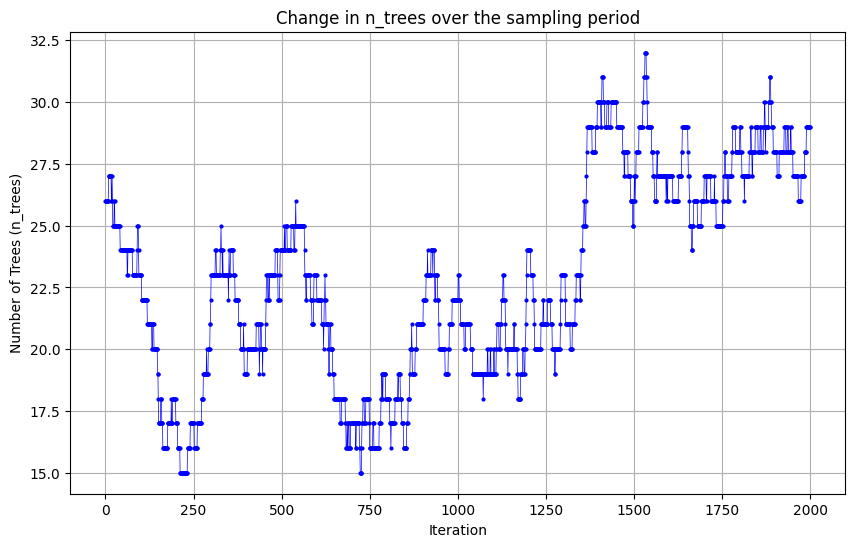

In [9]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [10]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-04-16 20:30:34,330:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-16 20:30:34,337:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.66 P_prune=0.34 A_grow=0.32 A_prune=0.30 (burnin)
Iteration 200/300 P_grow=0.52 P_prune=0.48 A_grow=0.27 A_prune=0.14
Iteration 300/300 P_grow=0.52 P_prune=0.48 A_grow=0.13 A_prune=0.36


In [11]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.17095174679976893,
 'rf': 0.02118006913369767,
 'lr': 0.048045521328019404,
 'btz': 0.02064869159091732}

In [12]:
print(f'Birth move count: {len(bart.sampler.birth_mh_ratios)}; mh median: {np.median(bart.sampler.birth_mh_ratios)}')

Birth move count: 973; mh median: 0.013043536790366506


In [13]:
print(f'Birth move likelihood median: {np.median(bart.sampler.birth_likelihood_ratios)}')

Birth move likelihood median: 0.07850026565857611


In [14]:
print(f'Death move count: {len(bart.sampler.death_mh_ratios)}; mh median: {np.median(bart.sampler.death_mh_ratios)}')

Death move count: 81; mh median: 16.565964479845082


In [15]:
print(f'Break move count: {len(bart.sampler.break_mh_ratios)}; mh median: {np.median(bart.sampler.break_mh_ratios)}')

Break move count: 358; mh median: 3.769014013945398


In [16]:
print(f'Combine move count: {len(bart.sampler.combine_mh_ratios)}; mh median: {np.median(bart.sampler.combine_mh_ratios)}')

Combine move count: 819; mh median: 0.2328632935491393


In [17]:
bart.trace[-1].trees

[Tree(vars=[ 0 -1 -1 -2], thresholds=[0.64139548        nan        nan        nan], leaf_vals=[       nan 0.03941718 0.0319039         nan], n_vals=[120  80  40  -2]),
 Tree(vars=[ 1 -1 -1 -2], thresholds=[0.04485528        nan        nan        nan], leaf_vals=[        nan  0.07777797 -0.02295073         nan], n_vals=[120   6 114  -2]),
 Tree(vars=[ 0  0 -1  0 -1 -2 -2 -1 -1 -2 -2 -2 -2 -2 -2 -2], thresholds=[0.8585056  0.29952342        nan 0.02712366        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan], leaf_vals=[        nan         nan -0.03213282         nan  0.02450419         nan
          nan -0.00751415 -0.03070018         nan         nan         nan
          nan         nan         nan         nan], n_vals=[120 106  14  42  64  -2  -2   3  39  -2  -2  -2  -2  -2  -2  -2]),
 Tree(vars=[ 1 -1 -1 -2], thresholds=[0.66884104        nan        nan        nan], leaf_vals=[       nan 0.03346958 0.0

In [18]:
X_sample = X_test[0].reshape(1, -1)
X_sample

array([[0.69426244, 0.58111661]])

In [19]:
y_test[0]

0.574943389972774

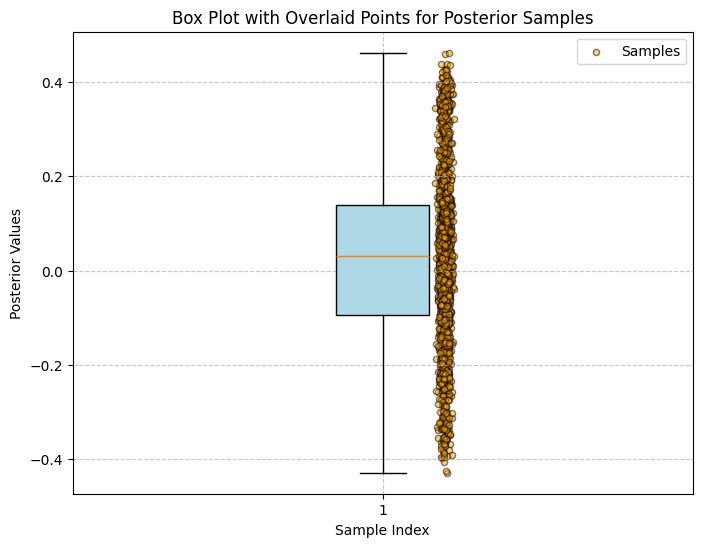

In [20]:
import matplotlib.pyplot as plt
import numpy as np

posterior_values = bart.posterior_f(X_sample)

plt.figure(figsize=(8, 6))
plt.boxplot(posterior_values[0], vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
for i in range(posterior_values.shape[1]):
    y = posterior_values[:, i]
    x = np.random.normal(1.1, 0.005, size=len(y))
    plt.scatter(x, y, alpha=0.5, color='orange', edgecolor='k', s=20, label='Samples' if i == 0 else None)

plt.title('Box Plot with Overlaid Points for Posterior Samples')
plt.ylabel('Posterior Values')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [21]:
eval_single = [float(bart.trace[0].trees[i].evaluate(X_sample)) for i in range(len(bart.trace[0].trees))]
eval_single

C:\Windows\Temp\ipykernel_24260\2762851684.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eval_single = [float(bart.trace[0].trees[i].evaluate(X_sample)) for i in range(len(bart.trace[0].trees))]


[0.006935168845622521,
 0.04422530182465448,
 0.03122841351413884,
 -0.07939107497036359,
 0.040248124590710255,
 0.01586953140144444,
 0.025326175733020546,
 -0.002299330406910525,
 -0.09755456978965257,
 0.07759806959369388,
 -0.0067782525650431896,
 0.075889806765917,
 -0.018965856428115154,
 -0.030658708244986142,
 -0.021094914819164732,
 0.027993508784557863,
 0.03483070440042269,
 0.053065544516811905,
 0.005474315953731278,
 -0.042485883743735846,
 -0.005798164384765948,
 -0.027082270011926757,
 -0.048184267913362354,
 -0.08003097558133089,
 -0.009756199874474512,
 0.03663607470866819]

In [22]:
len(eval_single)

26

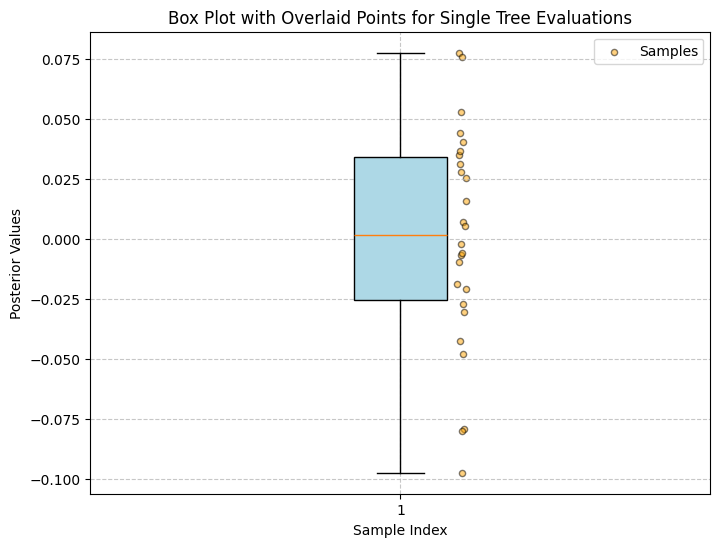

In [23]:
plt.figure(figsize=(8, 6))
plt.boxplot(eval_single, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
for i in range(len(eval_single)):
    y = eval_single[i]
    x = np.random.normal(1.1, 0.005, size=1)
    plt.scatter(x, y, alpha=0.5, color='orange', edgecolor='k', s=20, label='Samples' if i == 0 else None)

plt.title('Box Plot with Overlaid Points for Single Tree Evaluations')
plt.ylabel('Posterior Values')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [24]:
np.sum(eval_single)

0.005240271899561687

In [25]:
eval = [bart.trace[i].evaluate(X_sample) for i in range(len(bart.trace))]
eval

[array([0.00524027]),
 array([-0.00107574]),
 array([0.00644207]),
 array([0.00235535]),
 array([-0.00666679]),
 array([0.05046849]),
 array([0.03484519]),
 array([0.03332926]),
 array([0.02608452]),
 array([0.02044401]),
 array([0.02414163]),
 array([0.03332211]),
 array([0.01796111]),
 array([0.00758128]),
 array([0.02151316]),
 array([0.07949549]),
 array([0.01306754]),
 array([-0.06520364]),
 array([-0.06253969]),
 array([-0.03112191]),
 array([-0.00985859]),
 array([-0.07057945]),
 array([-0.06621974]),
 array([-0.0380526]),
 array([-0.06735648]),
 array([-0.0934548]),
 array([-0.12075105]),
 array([-0.09014767]),
 array([-0.05117184]),
 array([-0.06161605]),
 array([-0.0480064]),
 array([-0.06457543]),
 array([-0.11154882]),
 array([-0.08624904]),
 array([-0.10740341]),
 array([-0.09966849]),
 array([-0.0746358]),
 array([-0.0750485]),
 array([-0.09825045]),
 array([-0.08020513]),
 array([-0.08210683]),
 array([-0.06787372]),
 array([-0.14923298]),
 array([-0.14913337]),
 array([

In [26]:
y_test

array([ 0.57494339, -0.39107825,  0.03833771, -0.10585361,  0.58205285,
       -0.46879905, -0.12964723,  0.48524713,  0.30069396,  0.48688625,
        0.49330468,  0.4528224 ,  0.5750869 ,  0.55541165,  0.43010696,
        0.6155312 ,  0.44660998,  0.51601906,  0.48824578,  0.18206462,
        0.37483528, -0.15720403,  0.57823503,  0.43025762,  0.56087615,
        0.49741372, -0.02658388,  0.4874991 ,  0.04278904, -0.06782644,
       -0.03427862,  0.54396366,  0.52023062, -0.14805365,  0.61774119,
        0.54746971,  0.58137637, -0.46316434,  0.29964777,  0.55300647])

In [27]:
btpred

array([ 0.40027127, -0.36974826, -0.04369469,  0.17521988,  0.5945434 ,
       -0.36357448,  0.19078173,  0.588128  ,  0.5661116 ,  0.47713825,
        0.44868416,  0.59526557,  0.56653893,  0.3868277 ,  0.40706837,
        0.47647512,  0.57642955,  0.56330544,  0.48124167,  0.31324658,
        0.5614617 ,  0.08999559,  0.5178503 ,  0.48676   ,  0.4747114 ,
        0.47894338, -0.3567964 ,  0.4395098 ,  0.0022236 ,  0.16685785,
        0.03964119,  0.49061194,  0.4325004 ,  0.05185891,  0.5157671 ,
        0.46026233,  0.45548627, -0.4450927 ,  0.49567193,  0.5459732 ],
      dtype=float32)

In [28]:
y_pred = bart.predict(X_test)
y_pred

array([ 0.03305935,  0.01324087,  0.02384606,  0.03094937,  0.03571876,
        0.02858526,  0.01438914,  0.06080704,  0.06534526,  0.0463369 ,
        0.02427226,  0.0414271 ,  0.08170054,  0.02023037,  0.01437916,
        0.04617076,  0.0187305 ,  0.04879663,  0.06515165, -0.00862771,
        0.037904  ,  0.04190602,  0.01796937,  0.01207593,  0.05472058,
        0.05083044,  0.0282947 ,  0.0249383 , -0.00465288,  0.03484222,
        0.04716627,  0.04466533,  0.05630559,  0.03261998,  0.066741  ,
        0.04596995,  0.0409946 ,  0.05963182,  0.00294299,  0.01138768])